In [155]:
"""
Load all benchmarks
"""

import json
import matplotlib.pyplot as plt
import numpy as np

benchmarks = {}
sizes = [256,512,1024,2048,4096]
chances = [1,10,25,50,75,90,99]
iterations = range(1,11)

for size in sizes:
    benchmarks[size] = {}
    for chance in chances:
        benchmarks[size][chance] = {}
        for iteration in iterations:
            with open(f'./benchmarks/size_{size}/chance_{chance}/iteration_{iteration}.json', 'r') as f:
                benchmarks[size][chance][iteration] = json.load(f)

In [156]:
"""
Sanity check all benchmarks
"""

for size in sizes:
    for chance in chances:
        for iteration in iterations:
            benchmark = benchmarks[size][chance][iteration]
            assert(benchmark["result"] == 1)
            assert(benchmark["graphSize"] == size)
            assert(benchmark["edgeChance"] == chance)
            assert(benchmark["seed"] == iteration)
            assert(benchmark["triangles"] == benchmark["trianglesVerifier"])

In [157]:
"""
Prepare data for plotting
"""

avgTimeCounting = { "chance": {}, "size": {} }
avgTimeVerifier = { "chance": {}, "size": {} }
avgTimeProver = { "chance": {}, "size": {} }

for size in sizes:
    avgTimeCounting["size"][size] = {}
    avgTimeVerifier["size"][size] = {}
    avgTimeProver["size"][size] = {}
    for chance in chances:
        timeCounting = 0
        timeVerifier = 0
        timeProver = 0
        for iteration in iterations:
            benchmark = benchmarks[size][chance][iteration]
            timeCounting += benchmark["timeCounting"]
            timeVerifier += benchmark["timeVerifier"]
            timeProver += benchmark["timeProver"]
        avgTimeCounting["size"][size][chance] = timeCounting / len(iterations)
        avgTimeVerifier["size"][size][chance] = timeVerifier / len(iterations)
        avgTimeProver["size"][size][chance] = timeProver / len(iterations)

for chance in chances:
    avgTimeCounting["chance"][chance] = {}
    avgTimeVerifier["chance"][chance] = {}
    avgTimeProver["chance"][chance] = {}
    for size in sizes:
        avgTimeCounting["chance"][chance][size] = avgTimeCounting["size"][size][chance]
        avgTimeVerifier["chance"][chance][size] = avgTimeVerifier["size"][size][chance]
        avgTimeProver["chance"][chance][size] = avgTimeProver["size"][size][chance]

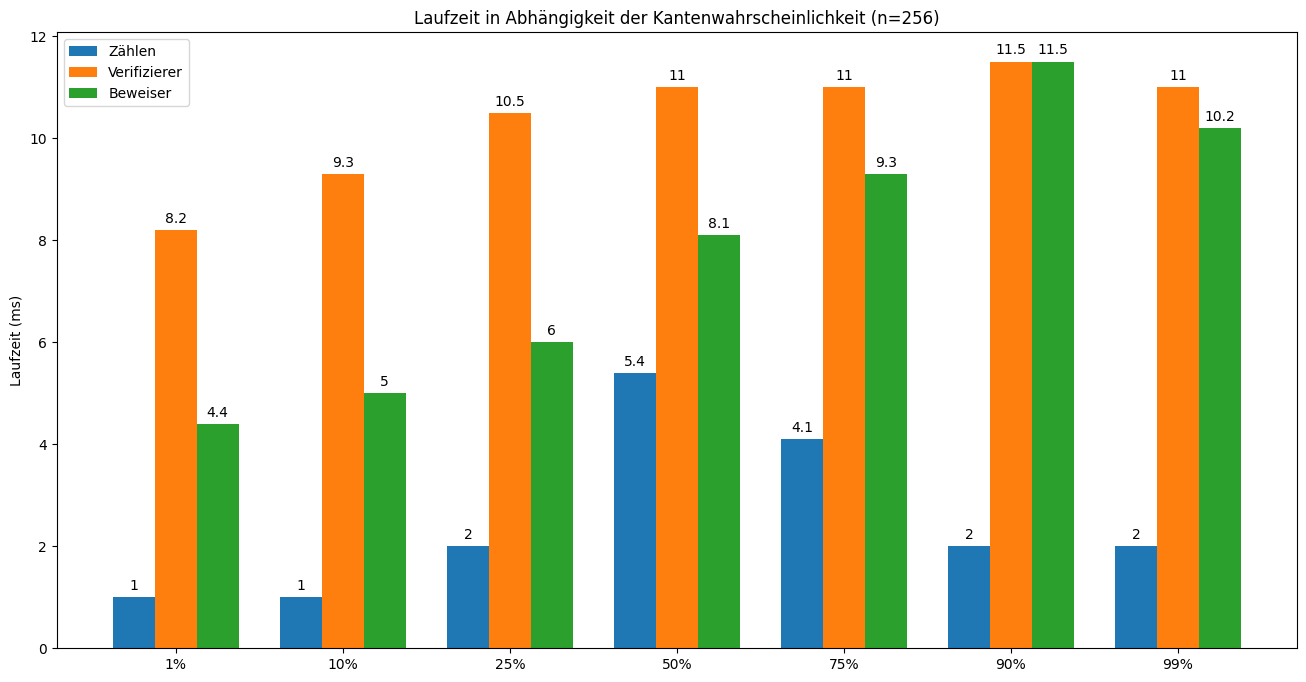

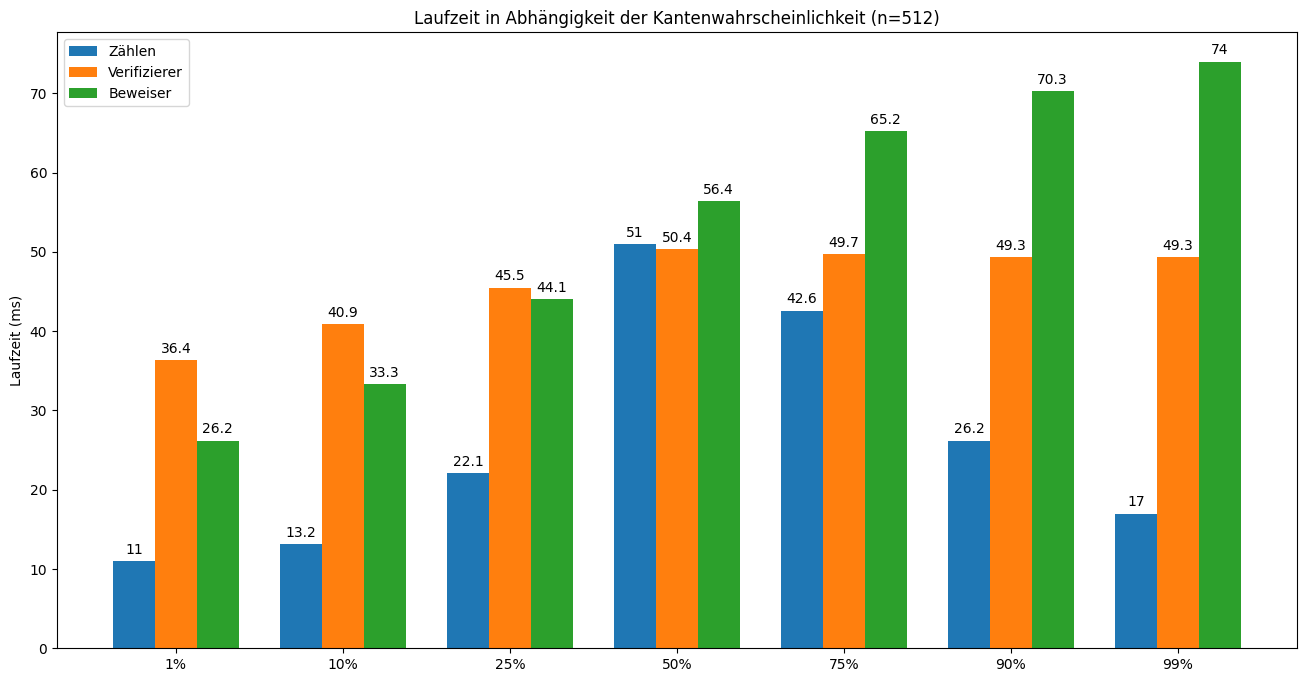

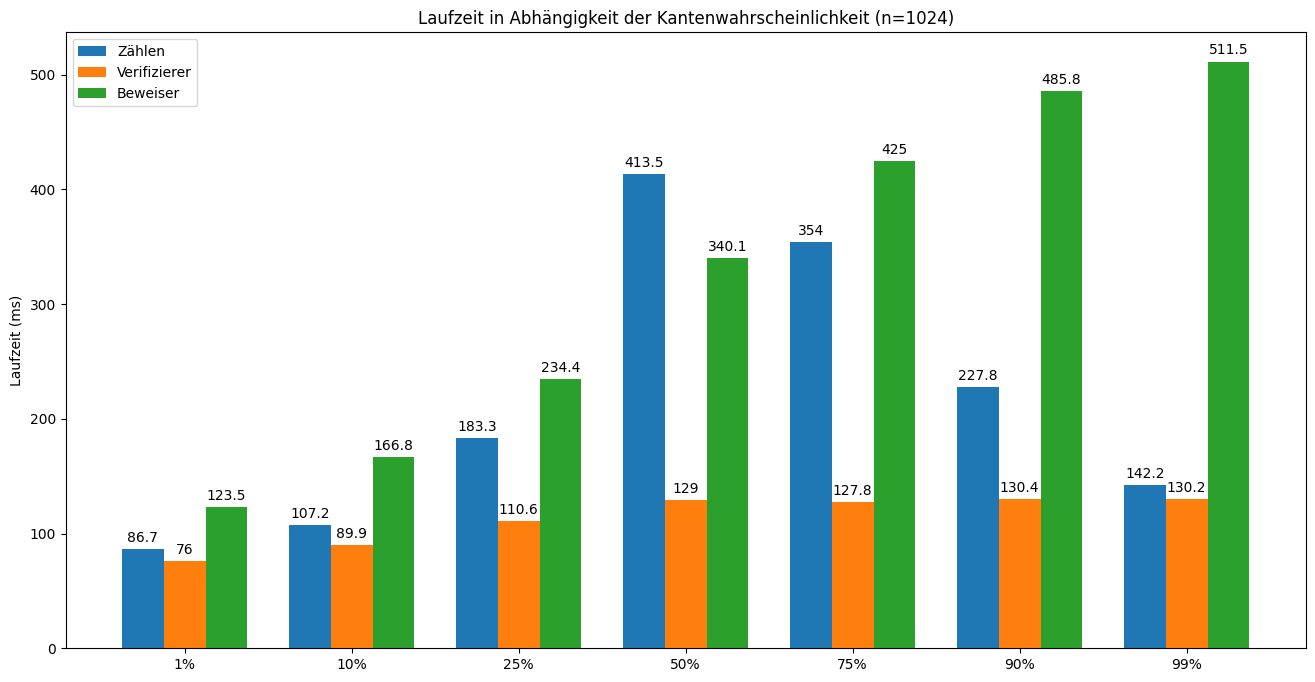

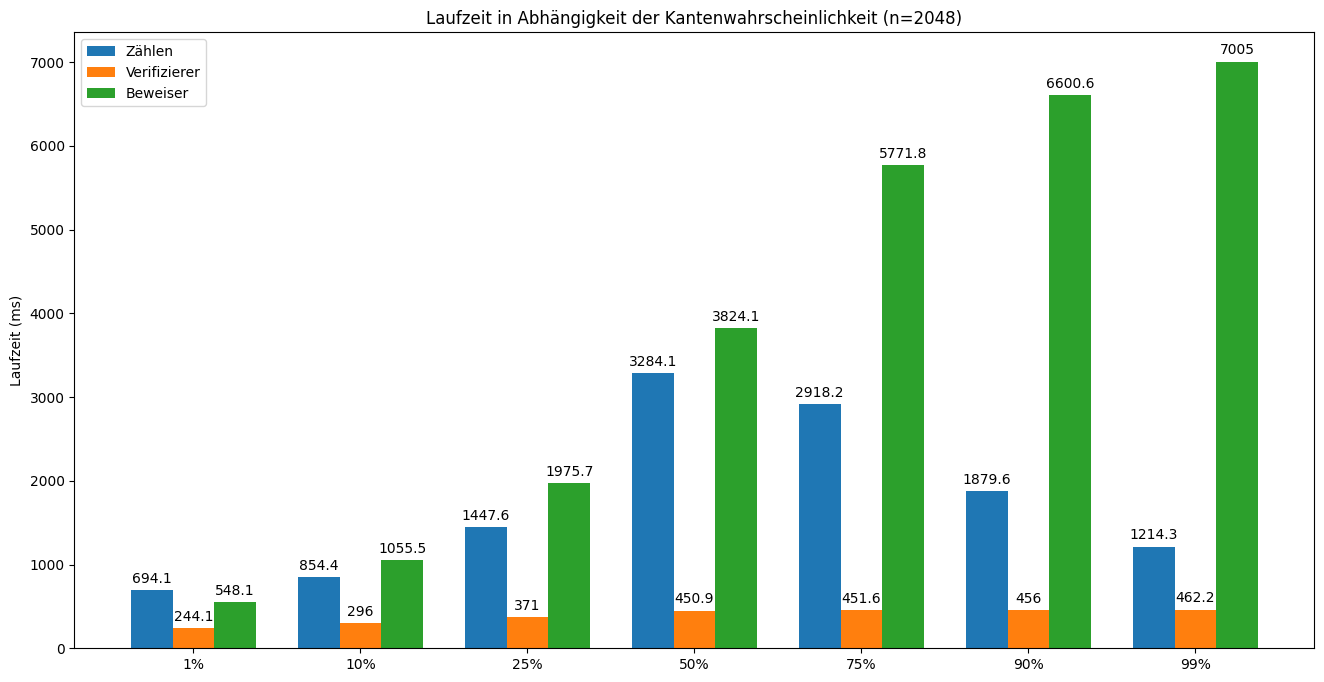

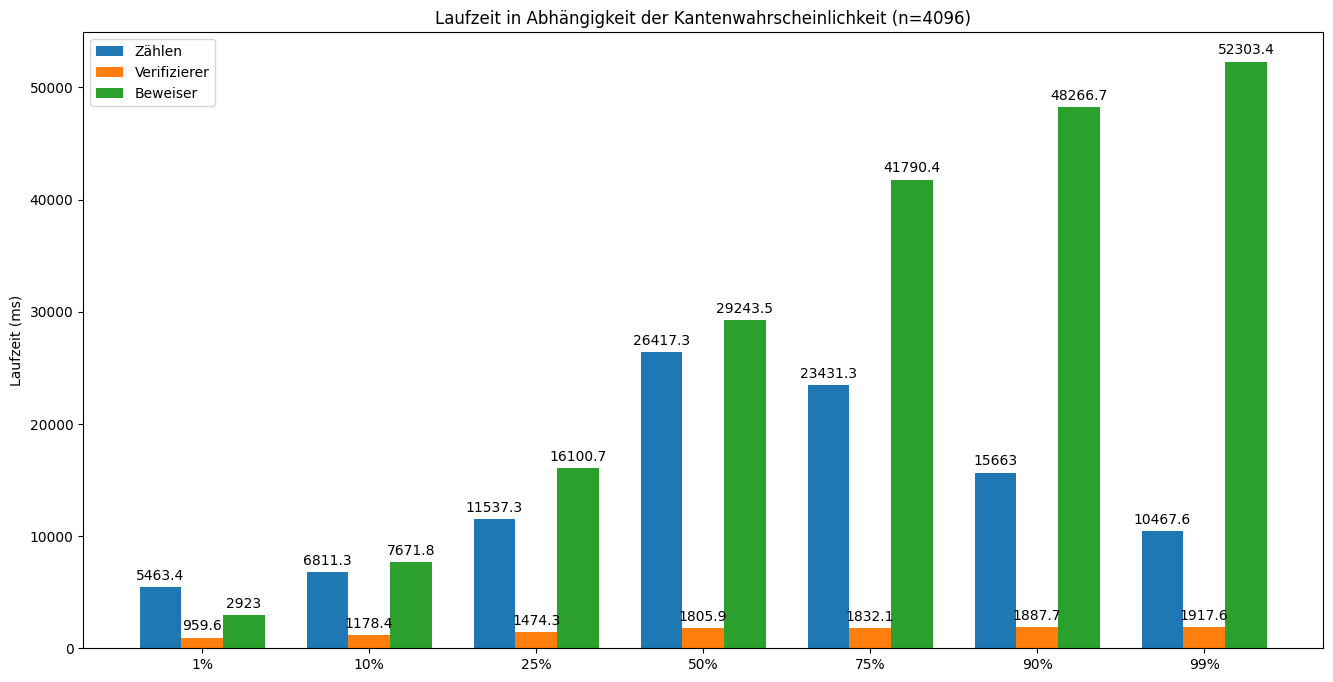

In [158]:
"""
Plot runtime dependent on edge chance
"""

def plot_runtime_dependent_on_chance(size):
    _, ax = plt.subplots(figsize=(16,8))

    x = np.arange(7)  # the label locations 
    width = 0.25  # the width of the bars
    multiplier = 0

    lists_counting = sorted(avgTimeCounting["size"][size].items()) 
    _, y_counting = zip(*lists_counting)

    lists_verifier = sorted(avgTimeVerifier["size"][size].items()) 
    _, y_verifier = zip(*lists_verifier)

    lists_prover = sorted(avgTimeProver["size"][size].items()) 
    _, y_prover = zip(*lists_prover)

    y = (y_counting, y_verifier, y_prover)
    
    for i, label in enumerate(["Zählen", "Verifizierer", "Beweiser"]):
        rects = []
        offset = width * multiplier

        rects = (ax.bar(x + offset, y[i], width, label=label))

        ax.bar_label(rects, padding=3)
        
        multiplier += 1

    ax.set_ylabel("Laufzeit (ms)")
    ax.set_title(f"Laufzeit in Abhängigkeit der Kantenwahrscheinlichkeit (n={size})")
    ax.set_xticks(x + width, [str(chance)+"%" for chance in chances])
    ax.legend(loc='upper left')

    plt.show()

for size in sizes:
    plot_runtime_dependent_on_chance(size)

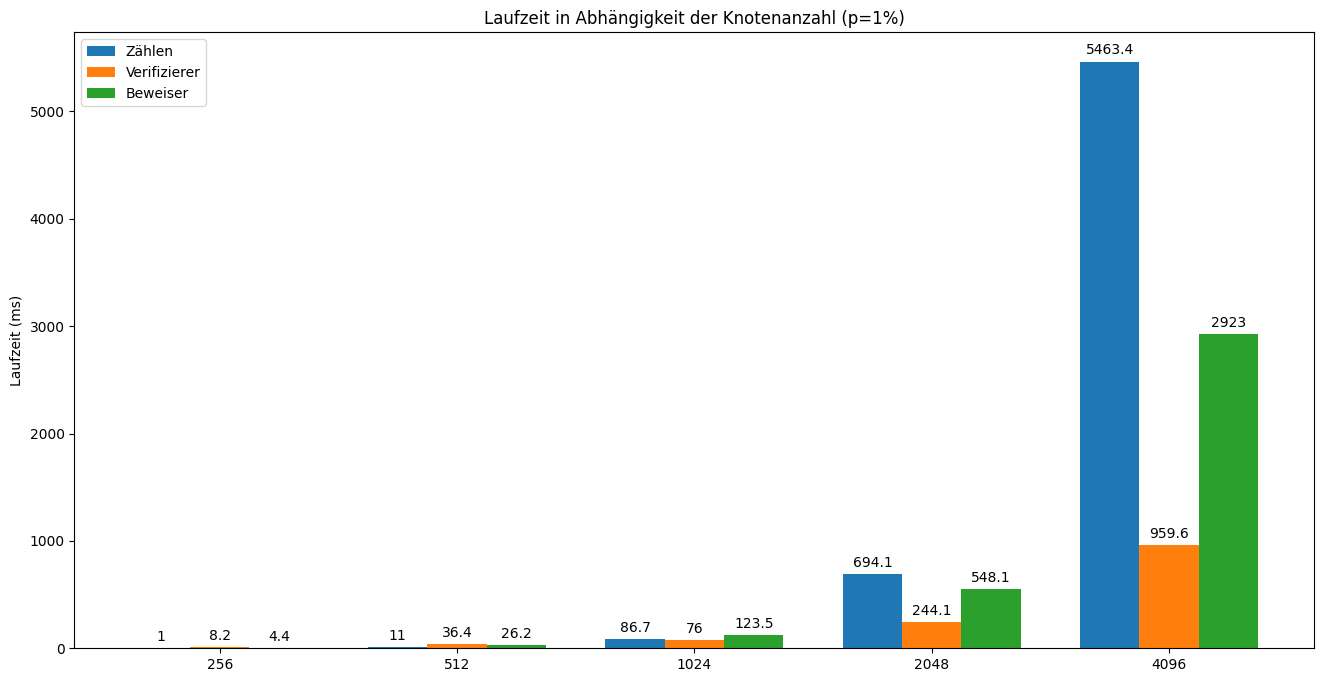

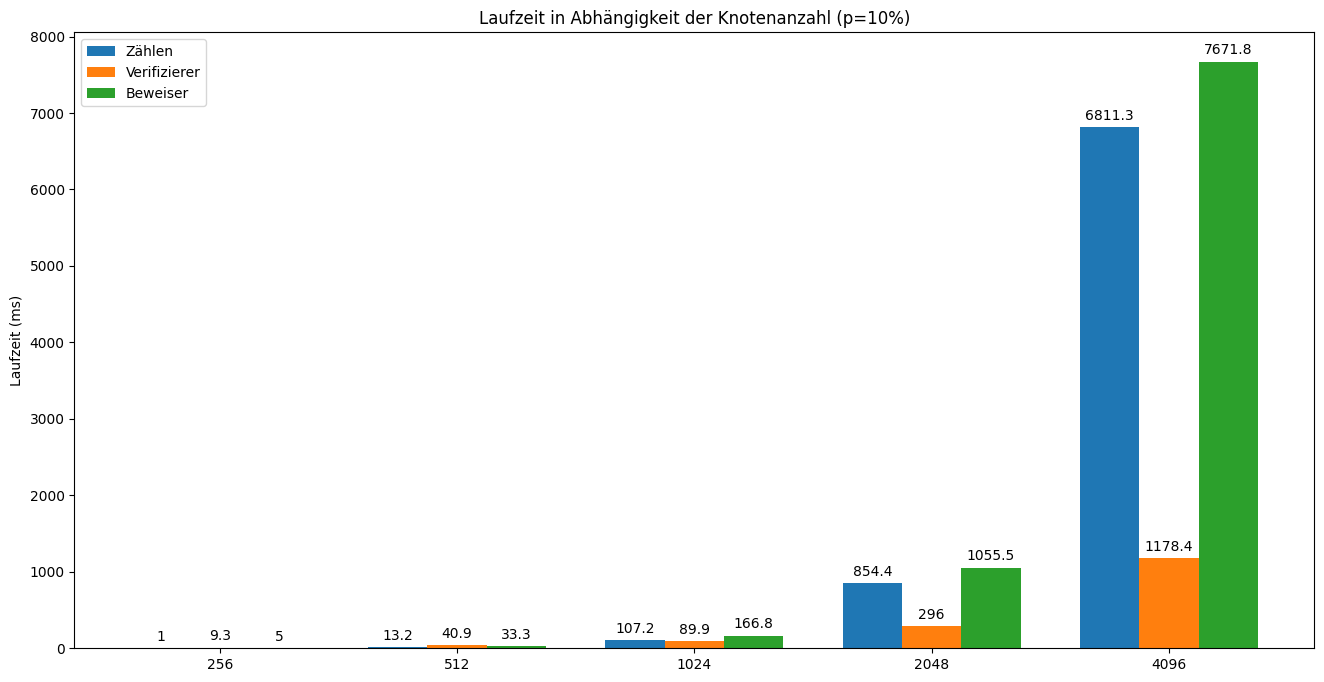

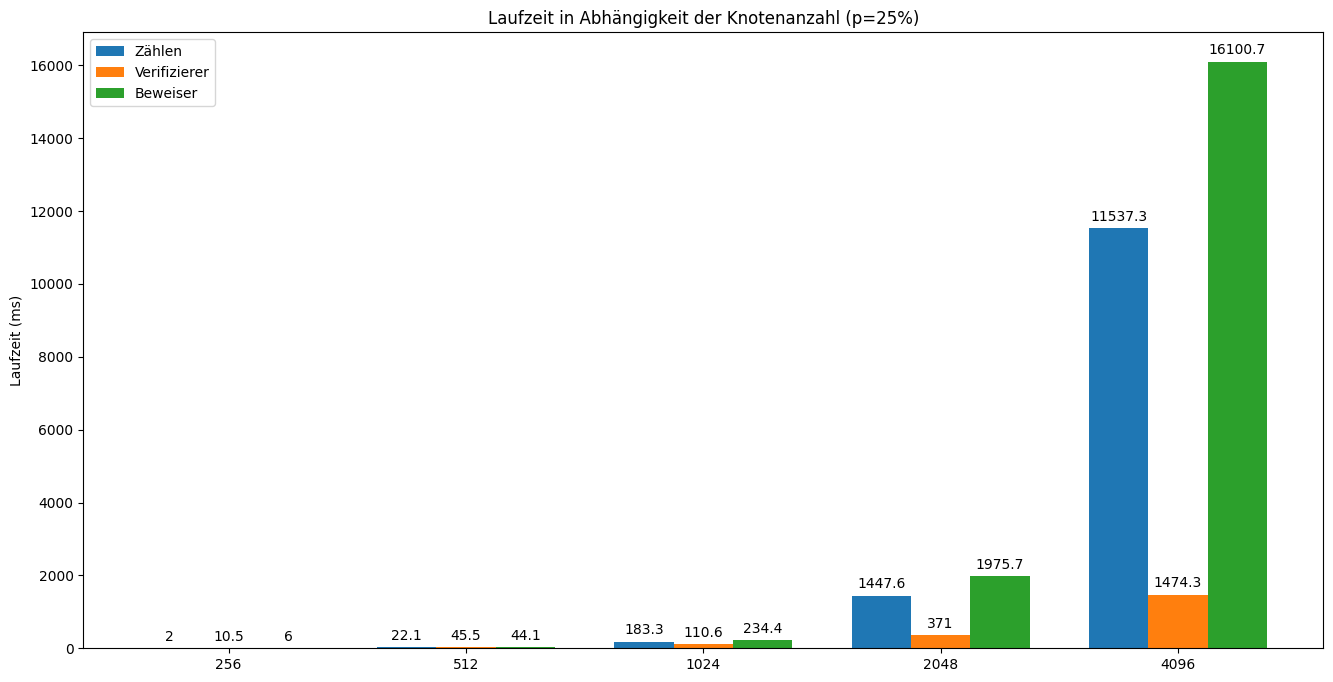

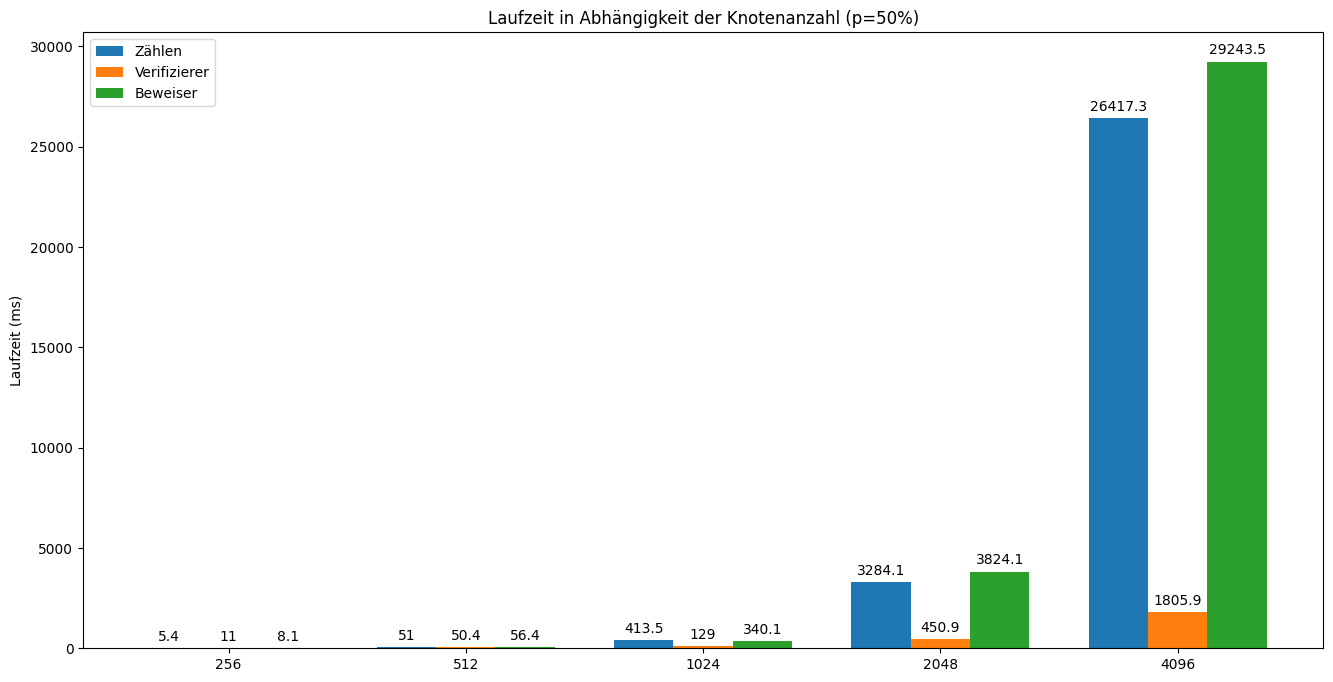

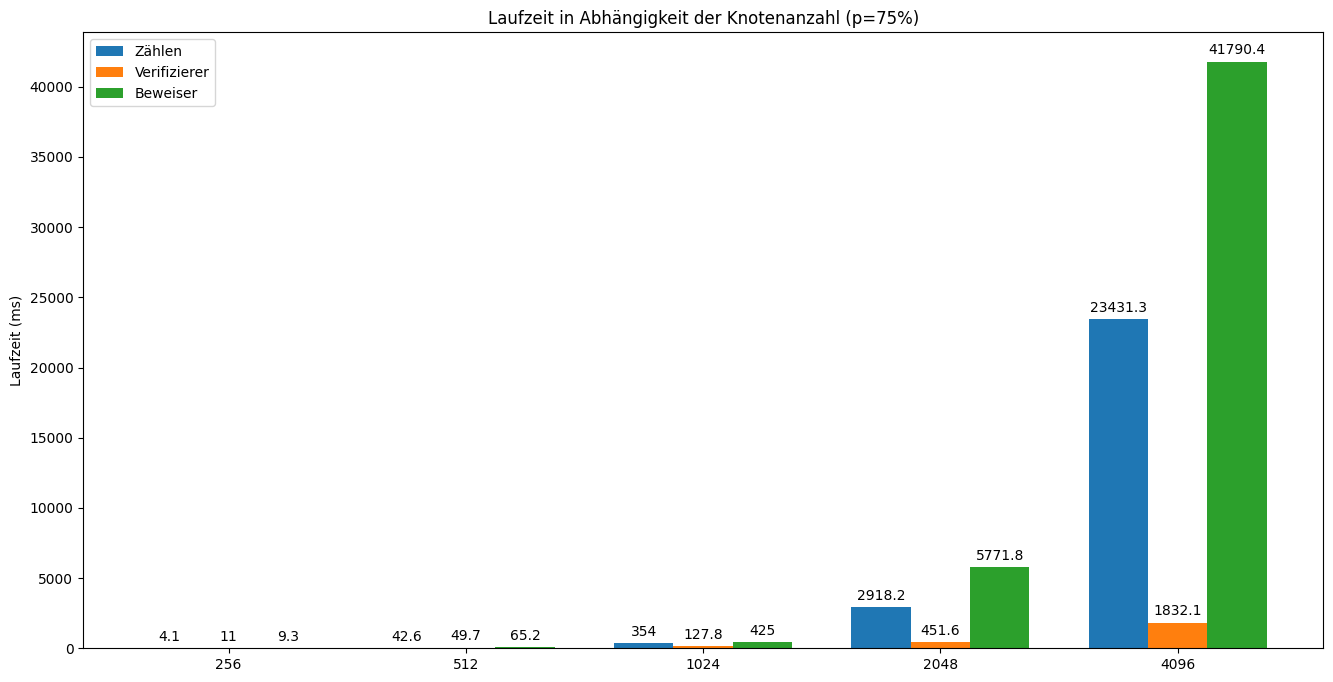

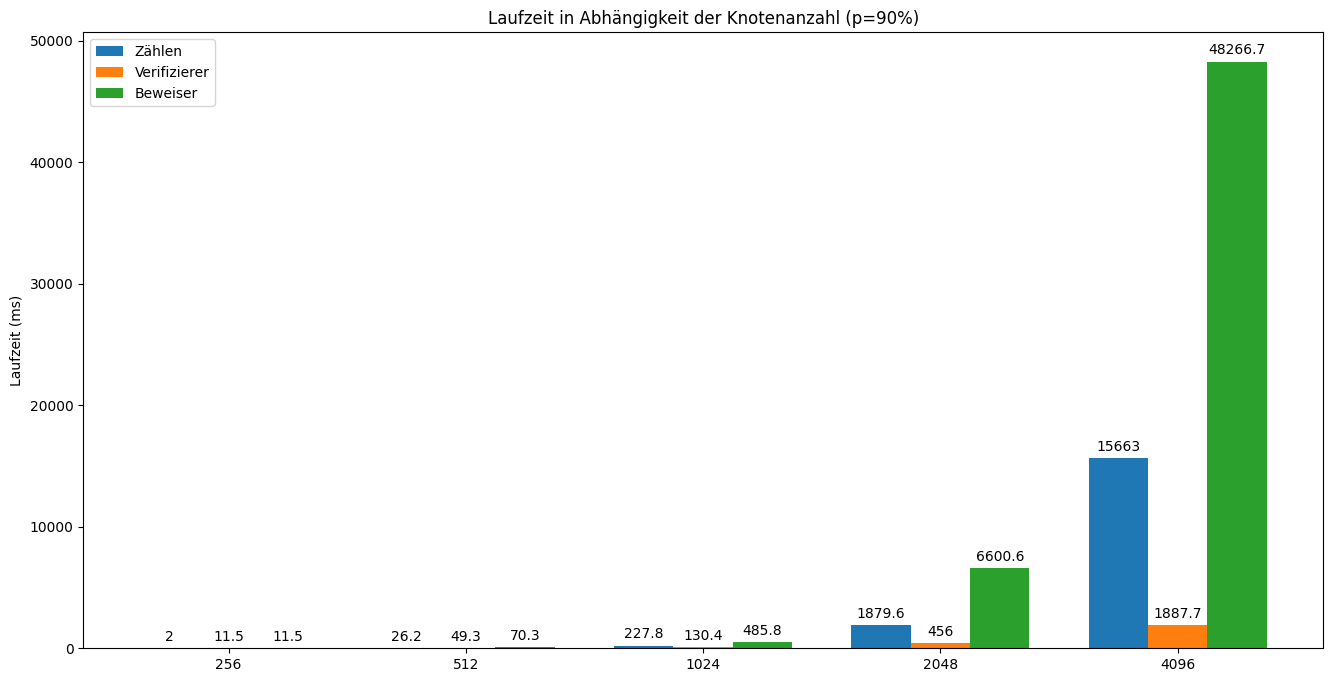

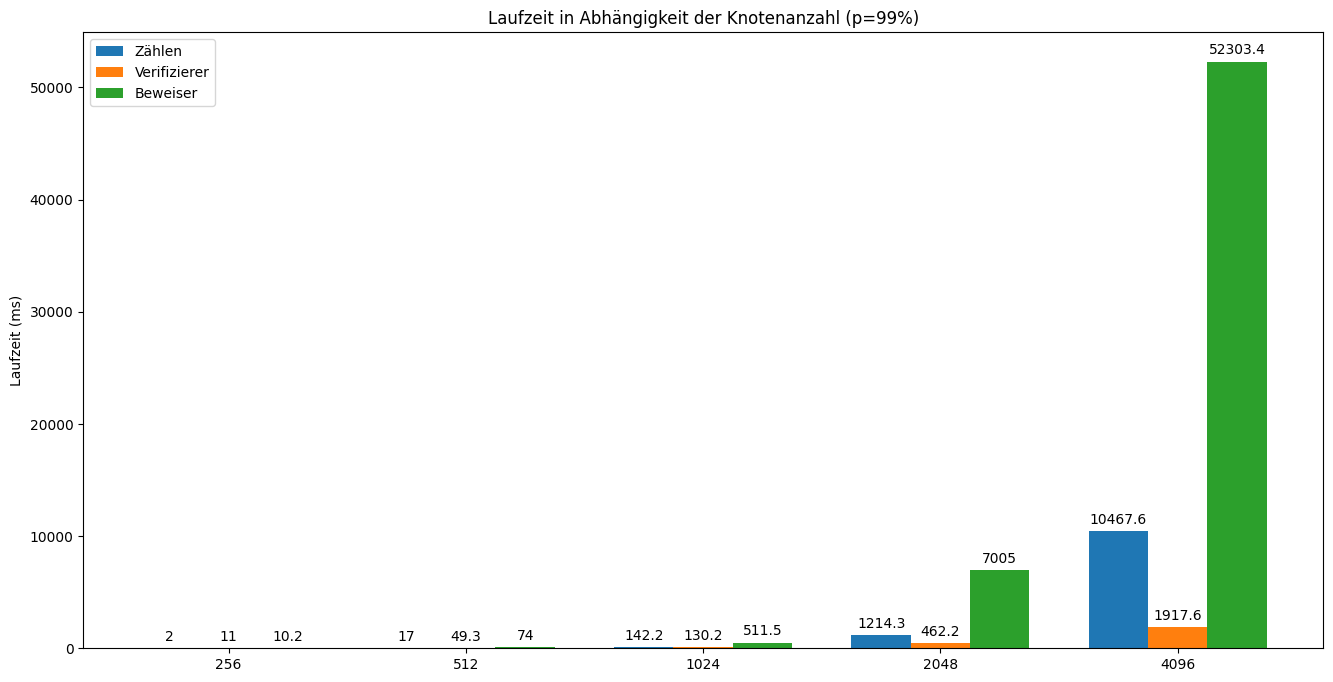

In [159]:
"""
Plot runtime dependent on size
"""

def plot_runtime_dependent_on_size(chance):
    _, ax = plt.subplots(figsize=(16,8))

    x = np.arange(len(sizes))  # the label locations 
    width = 0.25  # the width of the bars
    multiplier = 0

    lists_counting = sorted(avgTimeCounting["chance"][chance].items()) 
    _, y_counting = zip(*lists_counting)

    lists_verifier = sorted(avgTimeVerifier["chance"][chance].items()) 
    _, y_verifier = zip(*lists_verifier)

    lists_prover = sorted(avgTimeProver["chance"][chance].items()) 
    _, y_prover = zip(*lists_prover)

    y = (y_counting, y_verifier, y_prover)
    
    for i, label in enumerate(["Zählen", "Verifizierer", "Beweiser"]):
        rects = []
        offset = width * multiplier

        rects = (ax.bar(x + offset, y[i], width, label=label))

        ax.bar_label(rects, padding=3)
        
        multiplier += 1

    ax.set_ylabel("Laufzeit (ms)")
    ax.set_title(f"Laufzeit in Abhängigkeit der Knotenanzahl (p={chance}%)")
    ax.set_xticks(x + width, [str(size) for size in sizes])
    ax.legend(loc='upper left')

    plt.show()

for chance in chances:
    plot_runtime_dependent_on_size(chance)